In [236]:
import pandas as pd
import numpy as np
import sys,os,math
import random
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
import pickle
#import seaborn as sns
#from matplotlib_colorbar.colorbar import Colorbar

MARKERS = ['^', '<', 'o', 's', '+', '>']
HATCHES = ['//', '--', '\\\\', '||', '++', '--', '..', '++', '\\\\']
GRAYS = ['#2F4F4F', '#808080', '#A9A9A9', '#778899', '#DCDCDC', '#556677', '#1D3E3E', '#808080', '#DCDCDC']
COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
LINES = ['-', '-.']

OUTPUT_PATH = 'figures'

off_dict = {"edf+spt":"EDF-SPT", "edf+bf": "EDF-BF", "edf+wf":"EDF-WF", "lpt+ff":"LPT-FF"}
on_dict = {"edf+spt":"EDL", "edf+bin": "BIN"}


In [250]:
fsize = 22

def solve_dvfs(app, narrow=True):

    """
       default: Vc: 0.8, 1.24
                Fc: 0.89, 
                Fm: 0.8, 1.1
    """
    
    v_min = 0.5
    v_max = 1.2
    v_step = 15
    fm_min = 0.5
    fm_max = 1.2
    
    if narrow:
        v_min = 0.8
        v_max = 1.2
        v_step = int((v_max - v_min) / 0.05) + 1 # 10
        fm_min = 0.8 # 0.8
        fm_max = 1.2 # 1.1
    else:
        app["p0"] /= 13 # static power is too large
        app["gamma"] /= 13 # the part related to fm is too large

    if app["delta"] == 0:
        app["delta"] = 0.01

    fc_hat = 1
    fm_hat = 1
    v_hat = 1
    t_hat = app["t0"] + app["D"] * (app["delta"] / fc_hat + (1 - app["delta"]) / fm_hat)
    p_hat = app["p0"] + app["gamma"] * fm_hat + app["cg"] * (v_hat**2) * fc_hat
    e_hat = t_hat * p_hat
    e_star = e_hat
    for v_adj in range(0, v_step):
        v = v_min + 0.05 * v_adj
        fc = math.sqrt((v - 0.5) / 2.0) + 0.5
        fm = math.sqrt((app["p0"]+app["cg"]*(v**2)*fc)*app["D"]*(1-app["delta"]) / (app["gamma"] * (app["t0"] + app["D"]*app["delta"]/fc)))
        if fm <= fm_min:
            fm = fm_min
        if fm >= fm_max:
            fm = fm_max

        t_cur = app["t0"] + app["D"] * (app["delta"] / fc + (1 - app["delta"]) / fm)
        p_cur = app["p0"] + app["gamma"] * fm + app["cg"] * (v**2) * fc
        e_cur = t_cur * p_cur

        if e_cur < e_hat:
            e_hat = e_cur
            v_hat = v
            fc_hat = fc
            fm_hat = fm
            t_hat = t_cur
            p_hat = p_cur
    return (e_star - e_hat) / e_star, fc_hat, fm_hat, v_hat

def plot_app(apps='apps.pkl', save_filename=None):
    f = open(apps, 'rb')
    tmp_dict = pickle.load(f)
    f.close()
    
    apps = list(tmp_dict.values())
    narrow_data = [[] for i in range(4)]
    for app in apps:
        es, fc, fm, vc = solve_dvfs(app, narrow=True)
        narrow_data[0].append(es)
        narrow_data[1].append(fc)
        narrow_data[2].append(fm)
        narrow_data[3].append(vc)
    narrow_data = np.array(narrow_data)[:, :20]
    narrow_data[0, :] *= 100
    print(np.mean(narrow_data[0, :]))
    
    apps = list(tmp_dict.values())
    wide_data = [[] for i in range(4)]
    for app in apps:
        es, fc, fm, vc = solve_dvfs(app, narrow=False)
        wide_data[0].append(es)
        wide_data[1].append(fc)
        wide_data[2].append(fm)
        wide_data[3].append(vc)
    wide_data = np.array(wide_data)[:, :20]
    wide_data[0, :] *= 100
    print(np.mean(wide_data[0, :]))
    
    fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (15, 18), gridspec_kw = {'height_ratios':[1, 1, 1, 1]})

    ylabels = ["Energy Saving (%)", "Normalized Core\n Frequency", "Normalized Memory\n Frequency", "Normalized Core\n Voltage"]
    for ax_id in range(len(axes)):
        ax = axes[ax_id]
        bar_width = 6
        x_axis = np.arange(20) * (2+1.5) * bar_width - 2.5 * bar_width
        x_ticks = x_axis
        ax.bar(x_axis, narrow_data[ax_id], bar_width, alpha=0.8, label="Narrow", \
                color=GRAYS[0], edgecolor='black')
        x_axis = x_axis + bar_width * 1.25
        ax.bar(x_axis, wide_data[ax_id], bar_width, alpha=0.8, label="Wide", \
                color=GRAYS[4], edgecolor='black')

        ax.set_ylabel(ylabels[ax_id], size = fsize)
        top = ax.get_ylim()[1] * 1.3
        ax.set_ylim(top=top)
        ax.yaxis.set_tick_params(labelsize=fsize)
        ax.yaxis.offsetText.set_fontsize(fsize)

        #ax.set_xlabel('Application ID', size = fsize)
        #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
        ax.xaxis.set_tick_params(labelsize=fsize)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(np.arange(20)+1, size=fsize, rotation=0)

        ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
        ax.legend(fontsize=fsize, loc='upper center', ncol=5)
        plt.subplots_adjust(hspace = 0.3)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')

def plot_online_saving(df, save_filename=None):

    fig, ax = plt.subplots(figsize = (20, 6))

    algo = "edf+spt"
    
    ls = [1, 2, 4, 8, 16]
    #thetas = [0.8, 0.85, 0.9, 0.95, 1.0]
    thetas = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
    bar_width = 4
    x_axis = np.arange(len(ls)) * (len(thetas)+2.5) * bar_width - 2.5 * bar_width
    for idx in range(len(thetas)):
        al = algo
        theta = thetas[idx]
        tmp_df = df[(df.algo == al) & (df.dvfs_on == 1) & (df.theta == theta)].sort_values(by = ['gpus_per_node'])
        base_df = df[(df.algo == al) & (df.dvfs_on == 0)].sort_values(by = ['gpus_per_node'])
        E = (1 - tmp_df["aver_total_E"].to_numpy() / base_df["aver_total_E"].to_numpy()) * 100
        label = r'$\theta=%.2f$' % theta
        tmp_x = x_axis + idx * bar_width * 1.25
        ax.bar(tmp_x, E, bar_width, alpha=0.8, label=label, \
                color=GRAYS[idx], hatch=HATCHES[idx], edgecolor='black')

    ax.set_ylabel("Energy Saving (%)", size = fsize)
    top = ax.get_ylim()[1] * 1.05
    ax.set_ylim(top=top, bottom=20)
    ax.yaxis.set_tick_params(labelsize=fsize)
    ax.yaxis.offsetText.set_fontsize(fsize)

    #ax.set_xlabel(r'$\theta$', size = fsize)
    #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
    ax.xaxis.set_tick_params(labelsize=fsize)
    ax.set_xticks(x_axis+2.5*bar_width)
    ax.set_xticklabels(['l=%d'%l for l in ls], size=fsize, rotation=0)

    ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
    ax.legend(fontsize=fsize, loc='upper center', ncol=8, handletextpad=0.2, columnspacing=1.2)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')
    

def plot_bar(df, save_filename=None):

    #fig, ax = plt.subplots(figsize = (15, 18))
    fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (15, 20), gridspec_kw = {'height_ratios':[1, 1, 1, 1]})

    algo = "edf+spt"
    keys = ["idle", "turnon", "run", "total"]
    titles = ["Idle Energy", "Turn-on Penalty", "Runtime Energy", "Total Energy"]
    
    for ax_id in range(len(axes)):
        ax = axes[ax_id]
        key = keys[ax_id]
        ls = [1, 2, 4, 8, 16]
        thetas = [0.8, 0.85, 0.9, 0.95, 1.0]
        bar_width = 4
        x_axis = np.arange(len(thetas)) * (len(ls)+2.5) * bar_width - 2.5 * bar_width
        for idx in range(len(thetas)):
            al = algo
            l = ls[idx]
            tmp_df = df[(df.algo == al) & (df.dvfs_on == 1) & (df.gpus_per_node == l)].sort_values(by = ['theta'])
            E = tmp_df["aver_%s_E" % key].to_numpy()
            label = 'l=%d' % l
            tmp_x = x_axis + idx * bar_width * 1.25
            ax.bar(tmp_x, E, bar_width, alpha=0.8, label=label, \
                    color=GRAYS[idx], hatch=HATCHES[idx], edgecolor='black')

        ax.set_ylabel("Energy Consumption (J)", size = fsize)
        top = ax.get_ylim()[1] * 1.25
        bottom = 0
        if ax_id == 2:
            top = ax.get_ylim()[1] * 0.955
            bottom = ax.get_ylim()[1] * 0.94
        if ax_id == 3:
            top = ax.get_ylim()[1] * 1.05
            bottom = ax.get_ylim()[1] * 0.7
        ax.set_ylim(top = top, bottom = bottom)
        #ax.set_ylim(top=8.07e7, bottom=7.9e7)
        ax.yaxis.set_tick_params(labelsize=fsize)
        ax.ticklabel_format(style='sci', scilimits=(10,2), axis='y')
        ax.yaxis.offsetText.set_fontsize(fsize)

        ax.set_xlabel(r'$\theta$', size = fsize)
        #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
        ax.xaxis.set_tick_params(labelsize=fsize)
        ax.set_xticks(x_axis+2.5*bar_width)
        ax.set_xticklabels(thetas, size=fsize, rotation=0)

        ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
        ax.legend(fontsize=fsize, loc='upper center', ncol=5)
        ax.set_title(titles[ax_id], size=fsize)
        plt.subplots_adjust(hspace = 0.5)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')


def plot_dist(df, save_filename=None):

    fig, ax = plt.subplots(figsize = (15, 6))

    #algos = ["edf+bf-on-1.0", "edf+wf-on-1.0", "edf+spt-on-1.0", "lpt+ff-on-1.0"]
    algos = ["edf+spt-off-1.0", "edf+spt-on-1.0", "edf+spt-on-0.9", "edf+bin-off-1.0", "edf+bin-on-1.0"]
    #algos = ["edf+bf-off-1.0", "edf+wf-off-1.0", "edf+spt-off-1.0", "lpt+ff-off-1.0", "edf+bf-on-1.0", "edf+wf-on-1.0", "edf+spt-on-1.0", "lpt+ff-on-1.0"]
    #algos = ["edf+spt-on-1.0", "edf+spt-on-0.95", "edf+spt-on-0.9", "edf+spt-on-0.85", "edf+spt-on-0.8"]
    
    ls = [1, 2, 4, 8, 16]
    bar_width = 4
    x_axis = np.arange(len(ls)) * (len(algos)+2.5) * bar_width - 2.5 * bar_width
    for idx, algo in enumerate(algos):
        al, dvfs, theta = algo.split("-")
        if dvfs == 'on':
            ds = 1
        else:
            ds = 0
        theta = float(theta)
        tmp_df = df[(df.algo == al) & (df.dvfs_on == ds) & (df.theta == theta)].sort_values(by = ['gpus_per_node'])
        idleEs = tmp_df["aver_idle_E"].to_numpy()
        turnonEs = tmp_df["aver_turnon_E"].to_numpy()
        runEs = tmp_df["aver_run_E"].to_numpy()
        
        label = on_dict[al]
        if dvfs == 'on':
            label += "-D " + r'($\theta=%.1f$)' % theta
        lastBar = np.zeros(len(x_axis))
        tmp_x = x_axis + idx * bar_width * 1.25
        if idx == 0:
            ax.bar(tmp_x, idleEs, bar_width, alpha=0.8, bottom=lastBar, label=r'$E^{idle}$', \
                   color=GRAYS[0], hatch=HATCHES[0], edgecolor='black')
            lastBar += idleEs
            ax.bar(tmp_x, turnonEs, bar_width, alpha=0.8, bottom=lastBar, label=r'$E^{overhead}$', \
                   color=GRAYS[1], hatch=HATCHES[1], edgecolor='black')
            lastBar += turnonEs
            ax.bar(tmp_x, runEs, bar_width, alpha=0.8, bottom=lastBar, label=r'$E^{runtime}$', \
                   color=GRAYS[2], hatch=HATCHES[2], edgecolor='black')
            lastBar += runEs
        else:
            ax.bar(tmp_x, idleEs, bar_width, alpha=0.8, bottom=lastBar, \
                   color=GRAYS[0], hatch=HATCHES[0], edgecolor='black')
            lastBar += idleEs
            ax.bar(tmp_x, turnonEs, bar_width, alpha=0.8, bottom=lastBar, \
                   color=GRAYS[1], hatch=HATCHES[1], edgecolor='black')
            lastBar += turnonEs
            ax.bar(tmp_x, runEs, bar_width, alpha=0.8, bottom=lastBar, \
                   color=GRAYS[2], hatch=HATCHES[2], edgecolor='black')    
            lastBar += runEs
        for x, y in zip(tmp_x, lastBar):
            ax.text(x-bar_width/3, y+0.5e7, label, rotation='vertical', size=fsize-6)


    ax.set_ylabel("Energy Consumption (J)", size = fsize)
    ax.set_ylim(top = ax.get_ylim()[1] * 1.3)
    #ax.set_ylim(top=40, bottom=20)
    ax.yaxis.set_tick_params(labelsize=fsize)
    #ax.ticklabel_format(style='sci', scilimits=(1,1), axis='y')
    ax.yaxis.offsetText.set_fontsize(fsize)

    ax.set_xlabel(r'${log}_2l$', size = fsize)
    #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
    ax.xaxis.set_tick_params(labelsize=fsize)
    ax.set_xticks(x_axis+2.5*bar_width)
    ax.set_xticklabels(["l=%d"%l for l in ls], size=fsize, rotation=0)

    ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
    ax.legend(fontsize=fsize, loc='upper left', ncol=3)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')

def plot_curves(df, save_filename=None):

    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 5))#, gridspec_kw = {'height_ratios':[1, 1, 1, 1]})

    algos = ["edf+spt-off-1.0", "edf+spt-on-1.0", "edf+spt-on-0.9", "edf+bin-off-1.0", "edf+bin-on-1.0"]
    keys = ["idle", "turnon", "run"]
    titles = ["Idle Energy", "Turn-on Penalty", "Runtime Energy"]
    
    #df = df[(df.gpus_per_node == l)]
    df = df[(df.util == 1.6)]

    #x_axis = np.arange(1, 9) * 0.2
    x_axis = np.arange(5)
    for ax_id in range(len(axes)):
        ax = axes[ax_id]
        for idx, algo in enumerate(algos):
            al, dvfs, theta = algo.split("-")
            key = keys[ax_id]
            if dvfs == 'on':
                ds = 1
            else:
                ds = 0
            theta = float(theta)
            tmp_df = df[(df.algo == al) & (df.dvfs_on == ds) & (df.theta == theta)].sort_values(by = ['gpus_per_node'])
            #nds_df = df[(df.algo == al) & (df.dvfs_on == 0) & (df.theta == 1.0)].sort_values(by = ['gpus_per_node'])
            avers = tmp_df["aver_%s_E" % key].to_numpy() #/ nds_df["aver_%s_E" % key].to_numpy()
            mins = tmp_df["min_%s_E" % key].to_numpy() #/ nds_df["min_%s_E" % key].to_numpy()
            maxs = tmp_df["max_%s_E" % key].to_numpy() #/ nds_df["max_%s_E" % key].to_numpy()
            label = on_dict[al]
            if dvfs == 'on':
                label += "-D " + r'($\theta=%.1f$)' % theta
            ax.plot(x_axis, avers, linewidth = 1.5, color = COLORS[idx], linestyle='-', \
                    marker = MARKERS[idx], markersize = 12, markeredgecolor = 'k', \
                    label = label, markerfacecolor='none')
            #ax.fill_between(x_axis, mins, maxs, color=COLORS[idx], alpha=.1)

        #ax.set_ylabel("Energy Saving (%)", size = fsize)
        ax.set_ylabel("Energy Consumption (J)", size = fsize)
        if ax_id == 2:
            ax.set_ylim(top = ax.get_ylim()[1] * 1.6, bottom = 0)
        ax.yaxis.set_tick_params(labelsize=fsize)
        ax.ticklabel_format(style='sci', scilimits=(10,2), axis='y')
        ax.yaxis.offsetText.set_fontsize(fsize)

        ax.set_xlabel("Task Set Utilization", size = fsize)
        #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
        ax.xaxis.set_tick_params(labelsize=fsize)

        ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
        if ax_id == 0:
            ax.legend(fontsize=fsize-3, loc='upper left', ncol=1)
        ax.set_xlabel(r'${log}_2l$', size = fsize)
        ax.set_title(titles[ax_id], size=fsize)
        plt.subplots_adjust(wspace = 0.3)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')


def plot_offline_dvfs(df, save_filename=None):
    
    fig, ax = plt.subplots(figsize = (10, 8))
    #fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (23, 8))#, gridspec_kw = {'height_ratios':[1, 1, 1, 1]})
    offset = 8
    
    algos = ["edf+bf-off-1.0", "edf+wf-off-1.0", "edf+spt-off-1.0", "lpt+ff-off-1.0", \
             "edf+bf-on-1.0", "edf+wf-on-1.0", "edf+spt-on-1.0", "lpt+ff-on-1.0"]
    
    x_axis = np.arange(1, 9) * 0.2
    l = 1
    key = 'total'
    
    
    #ax = axes[0]
    for idx, algo in enumerate(algos):
        al, dvfs, theta = algo.split("-")
        if dvfs == 'on':
            ds = 1
        else:
            ds = 0
        
        tmp_df = df[(df.algo == al) & (df.gpus_per_node == l) & (df.dvfs_on == ds)].sort_values(by = ['util'])
            
        avers = tmp_df["aver_%s_E" % key].to_numpy() 
        mins = tmp_df["min_%s_E" % key].to_numpy() 
        maxs = tmp_df["max_%s_E" % key].to_numpy() 
            
        # saving
        #ds_df = df[(df.algo == algo) & (df.gpus_per_node == l) & (df.dvfs_on == 1)].sort_values(by = ['util'])
        #avers = (1 - ds_df["aver_%s_E" % key].to_numpy() / tmp_df["aver_%s_E" % key].to_numpy()) * 100
        #mins  = (1 - ds_df["min_%s_E" % key].to_numpy() / tmp_df["min_%s_E" % key].to_numpy()) * 100
        #maxs  = (1 - ds_df["max_%s_E" % key].to_numpy() / tmp_df["max_%s_E" % key].to_numpy()) * 100

        label = off_dict[al]
        if dvfs == 'on':
            label += " DVFS"

        ax.plot(x_axis, avers, linewidth = 1.5, color = COLORS[idx // 4], marker = MARKERS[idx % 4], \
                markersize = 15, markeredgecolor = 'k', label = label, markerfacecolor='none')
        ax.fill_between(x_axis, mins, maxs, color=COLORS[idx // 4], alpha=.1)

    #ax.set_ylabel("Normalized Energy", size = fsize+offset)
    ax.set_ylabel("Energy Consumption (J)", size = fsize+offset)
    ax.set_ylim(top = ax.get_ylim()[1] * 1.15)
    #ax.set_ylim(top = 1.35, bottom = 1.0)
    ax.yaxis.set_tick_params(labelsize=fsize+offset)
    #ax.ticklabel_format(style='sci', scilimits=(1,1), axis='y')
    ax.yaxis.offsetText.set_fontsize(fsize+offset)

    ax.set_xlabel("Task Set Utilization", size = fsize+offset)
    #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
    ax.xaxis.set_tick_params(labelsize=fsize+offset)
    ax.set_xticks(x_axis)
    #ax.set_xticklabels(["l=%d"%l for l in ls], size=fsize, rotation=0)

    ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
    ax.legend(fontsize=fsize+3, loc='upper left', ncol=2, handletextpad=0.2, columnspacing=0.4)
    ax.set_title("l=%d"%l, size=fsize+offset)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    
    '''
    #ax = axes[1]
    for idx, algo in enumerate(algos[:4]):
        al, dvfs, theta = algo.split("-")
        nds_df = df[(df.algo == al) & (df.gpus_per_node == l) & (df.dvfs_on == 0)].sort_values(by = ['util'])
        ds_df = df[(df.algo == al) & (df.gpus_per_node == l) & (df.dvfs_on == 1)].sort_values(by = ['util'])

        # saving
        avers = (1 - ds_df["aver_%s_E" % key].to_numpy() / nds_df["aver_%s_E" % key].to_numpy()) * 100
        mins  = (1 - ds_df["min_%s_E" % key].to_numpy() / nds_df["min_%s_E" % key].to_numpy()) * 100
        maxs  = (1 - ds_df["max_%s_E" % key].to_numpy() / nds_df["max_%s_E" % key].to_numpy()) * 100
    
        label = off_dict[al]
        if dvfs == 'on':
            label += " DVFS"

        ax.plot(x_axis, avers, linewidth = 1.5, color = COLORS[idx], marker = MARKERS[idx], \
                markersize = 15, markeredgecolor = 'k', label = label, markerfacecolor='none')
        #ax.fill_between(x_axis, mins, maxs, color=COLORS[idx], alpha=.1)

    #ax.set_ylabel("Normalized Energy", size = fsize+offset)
    ax.set_ylabel("Energy Saving(%)", size = fsize+offset)
    ax.set_ylim(top = 34.4, bottom = 33)
    #ax.set_ylim(top = 1.35, bottom = 1.0)
    ax.yaxis.set_tick_params(labelsize=fsize+offset)
    #ax.ticklabel_format(style='sci', scilimits=(1,1), axis='y')
    ax.yaxis.offsetText.set_fontsize(fsize+offset)

    ax.set_xlabel("Task Set Utilization", size = fsize+offset)
    #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
    ax.xaxis.set_tick_params(labelsize=fsize+offset)
    ax.set_xticks(x_axis)
    #ax.set_xticklabels(["l=%d"%l for l in ls], size=fsize, rotation=0)

    ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
    ax.legend(fontsize=fsize+3, loc='upper left', ncol=1)
    ax.set_title("l=%d"%l, size=fsize+offset)
    plt.subplots_adjust(wspace = 0.35, hspace = 0.35)
    '''
    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')
    

def plot_offline_theta(df, save_filename=None):
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (23, 20))#, gridspec_kw = {'height_ratios':[1, 1, 1, 1]})
    offset = 8
    
    ls = [2, 4, 8, 16]
    #algos = ["edf+spt-on-0.85", "edf+spt-on-0.9", "edf+spt-on-0.95", "edf+spt-on-1.0", "lpt+ff-on-1.0"]
    algos = ["edf+spt-on-0.1", "edf+spt-on-0.3", "edf+spt-on-0.5", "edf+spt-on-0.7", "edf+spt-on-0.9", "edf+spt-on-1.0"]

    x_axis = np.arange(1, 9) * 0.2
    key = 'total'
    for ax_id in range(4):
        l = ls[ax_id]
        ax = axes[ax_id // 2][ax_id % 2]
        for idx, algo in enumerate(algos):
            al, dvfs_on, theta = algo.split("-")
            theta = float(theta)
            print(al, dvfs_on, theta)
            tmp_df = df[(df.algo == al) & (df.gpus_per_node == l) & (df.dvfs_on == 0)].sort_values(by = ['util'])
            print(tmp_df)

            # saving
            ds_df = df[(df.algo == al) & (df.gpus_per_node == l) & (df.dvfs_on == 1) & (df.theta == theta)].sort_values(by = ['util'])
            avers = (1 - ds_df["aver_%s_E" % key].to_numpy() / tmp_df["aver_%s_E" % key].to_numpy()) * 100
            mins  = (1 - ds_df["min_%s_E" % key].to_numpy() / tmp_df["min_%s_E" % key].to_numpy()) * 100
            maxs  = (1 - ds_df["max_%s_E" % key].to_numpy() / tmp_df["max_%s_E" % key].to_numpy()) * 100
            
            if al == 'edf+spt':
                label = r'$\theta=%.2f$' % theta
            else:
                label = 'LPT-FF DVFS'
            ax.plot(x_axis, avers, linewidth = 1.5, color = COLORS[idx], marker = MARKERS[idx], \
                    markersize = 15, markeredgecolor = 'k', label = label, markerfacecolor='none')
            ax.fill_between(x_axis, mins, maxs, color=COLORS[idx], alpha=.1)

        #ax.set_ylabel("Normalized Energy", size = fsize+offset)
        ax.set_ylabel("Energy Saving (%)", size = fsize+offset)
        ax.set_ylim(top = 35, bottom=0)
        #ax.set_ylim(top = 1.35, bottom = 1.0)
        ax.yaxis.set_tick_params(labelsize=fsize+offset)
        #ax.ticklabel_format(style='sci', scilimits=(1,1), axis='y')
        ax.yaxis.offsetText.set_fontsize(fsize+offset)

        ax.set_xlabel("Task Set Utilization", size = fsize+offset)
        #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
        ax.xaxis.set_tick_params(labelsize=fsize+offset)
        ax.set_xticks(x_axis)
        #ax.set_xticklabels(["l=%d"%l for l in ls], size=fsize, rotation=0)

        ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
        ax.legend(fontsize=fsize+offset, loc='lower right', ncol=1)
        ax.set_title("l=%d"%l, size=fsize+offset)
        plt.subplots_adjust(wspace = 0.35, hspace = 0.35)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')
   
    
def plot_lcurves(df, save_filename=None):

    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (23, 20))#, gridspec_kw = {'height_ratios':[1, 1, 1, 1]})
    offset = 8
    
    ls = [2, 4, 8, 16]
    algos = ["edf+bf", "edf+wf", "edf+spt", "lpt+ff"]
    base_Es = df[(df.algo == "edf+spt") & (df.gpus_per_node == 1) & (df.util <= 1.6) & (df.dvfs_on == 0) & (df.theta == 1.0)].sort_values(by = ['util'])
    
    x_axis = np.arange(1, 9) * 0.2
    key = 'total'
    for ax_id in range(4):
        l = ls[ax_id]
        ax = axes[ax_id // 2][ax_id % 2]
        for idx, algo in enumerate(algos):
            tmp_df = df[(df.algo == algo) & (df.gpus_per_node == l) & (df.dvfs_on == 0) & (df.theta == 1.0)].sort_values(by = ['util'])
            # normalized
            avers = tmp_df["aver_%s_E" % key].to_numpy() / base_Es["aver_%s_E" % key].to_numpy()
            mins = tmp_df["min_%s_E" % key].to_numpy() / base_Es["min_%s_E" % key].to_numpy()
            maxs = tmp_df["max_%s_E" % key].to_numpy() / base_Es["max_%s_E" % key].to_numpy()
            
            # saving
            #ds_df = df[(df.algo == algo) & (df.gpus_per_node == l) & (df.dvfs_on == 1) & (df.theta == 1.0)].sort_values(by = ['util'])
            #avers = (1 - ds_df["aver_%s_E" % key].to_numpy() / base_Es["aver_%s_E" % key].to_numpy()) * 100
            #mins  = (1 - ds_df["min_%s_E" % key].to_numpy() / base_Es["min_%s_E" % key].to_numpy()) * 100
            #maxs  = (1 - ds_df["max_%s_E" % key].to_numpy() / base_Es["max_%s_E" % key].to_numpy()) * 100
            
            label = off_dict[algo]
            ax.plot(x_axis, avers, linewidth = 1.5, color = COLORS[idx], marker = MARKERS[idx], \
                    markersize = 15, markeredgecolor = 'k', label = label, markerfacecolor='none')
            #ax.fill_between(x_axis, mins, maxs, color=COLORS[idx], alpha=.1)

        ax.set_ylabel("Normalized Energy", size = fsize+offset)
        #ax.set_ylabel("Energy Saving (%)", size = fsize+offset)
        #ax.set_ylim(top = 60, bottom = 0)
        ax.set_ylim(top = 1.35, bottom = 1.0)
        ax.yaxis.set_tick_params(labelsize=fsize+offset)
        #ax.ticklabel_format(style='sci', scilimits=(1,1), axis='y')
        ax.yaxis.offsetText.set_fontsize(fsize+offset)

        ax.set_xlabel("Task Set Utilization", size = fsize+offset)
        #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
        ax.xaxis.set_tick_params(labelsize=fsize+offset)
        ax.set_xticks(x_axis)
        #ax.set_xticklabels(["l=%d"%l for l in ls], size=fsize, rotation=0)

        ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
        ax.legend(fontsize=fsize+offset, loc='upper left', ncol=1)
        ax.set_title("l=%d"%l, size=fsize+offset)
        plt.subplots_adjust(wspace = 0.35, hspace = 0.35)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')


def plot_real(save_filename=None):
    
    fig, ax = plt.subplots(figsize = (12, 6))
    ergs_defl = [656500, 632200, 689100]
    cpus_defl = [120800, 121500, 122300]
    times_defl = [491.2, 484.3, 508.6]
    ergs_dvfs = [624800, 586100, 652300] # [4.9%, 7.3%, 5.4%]
    cpus_dvfs = [113900, 109800, 116800]
    times_dvfs = [471.8, 453.8, 488.7]
    
    bar_width = 0.3
    x_axis = np.array([0, 1, 2])
    
    tmp_x = x_axis
    ax.bar(tmp_x, cpus_defl, bar_width, alpha=0.8, label='CPU', \
           color=GRAYS[0], edgecolor='black')
    ax.bar(tmp_x, ergs_defl, bar_width, alpha=0.8, bottom=cpus_defl, label='GPU', \
           color=GRAYS[4], edgecolor='black')
    for x, y in zip(tmp_x, (cpus_defl + ergs_defl)):
        ax.text(x-0.05, y+750000, 'EDL', rotation='vertical', size=fsize)
    tmp_x = x_axis + bar_width
    ax.bar(tmp_x, cpus_dvfs, bar_width, alpha=0.8,  \
           color=GRAYS[0], edgecolor='black')
    ax.bar(tmp_x, ergs_dvfs, bar_width, alpha=0.8, bottom=cpus_dvfs,  \
           color=GRAYS[4], edgecolor='black')
    for x, y in zip(tmp_x, (cpus_dvfs + ergs_dvfs)):
        ax.text(x-0.05, y+750000, 'EDL-D', rotation='vertical', size=fsize)
    
    #tax = ax.twinx()
    #tax.plot(x_axis, times_defl)
    #tax.plot(x_axis, times_dvfs)

    ax.set_ylabel('Energy (J)', size = fsize)
    top = ax.get_ylim()[1] * 1.55
    ax.set_ylim(top=top)
    ax.yaxis.set_tick_params(labelsize=fsize)
    ax.yaxis.offsetText.set_fontsize(fsize)

    ax.set_xlabel('Task set ID', size = fsize)
    ax.xaxis.set_tick_params(labelsize=fsize)
    ax.set_xticks([0.15, 1.15, 2.15])
    ax.set_xticklabels([1, 2, 3], size=fsize, rotation=0)

    ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
    ax.legend(fontsize=fsize, loc='upper center', ncol=5)
    plt.subplots_adjust(hspace = 0.3)
    
    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')
        
def plot_turnon(df, save_filename=None):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (23, 8))#, gridspec_kw = {'height_ratios':[1, 1, 1, 1]})
    offset = 8
    
    algos = ["edf+bf", "edf+wf", "edf+spt", "lpt+ff"]
    
    x_axis = np.arange(1, 9) * 0.2
    l = 1
    
    for ax_id in range(len(axes)):
        ax = axes[ax_id]
        for idx, algo in enumerate(algos):
            al = algo
            tmp_df = df[(df.algo == al) & (df.gpus_per_node == l) & (df.dvfs_on == ax_id)].sort_values(by = ['util'])  
            turnons = tmp_df['turnon'].to_numpy() 

            label = off_dict[al]
            if ax_id == 1:
                label += " DVFS"

            ax.plot(x_axis, turnons, linewidth = 1.5, color = COLORS[idx], marker = MARKERS[idx], \
                    markersize = 15, markeredgecolor = 'k', label = label, markerfacecolor='none')

        #ax.set_ylabel("Normalized Energy", size = fsize+offset)
        ax.set_ylabel("Occupied Servers", size = fsize+offset)
        ax.set_ylim(top=2200, bottom=0)
        ax.yaxis.set_tick_params(labelsize=fsize+offset)
        #ax.ticklabel_format(style='sci', scilimits=(1,1), axis='y')
        ax.yaxis.offsetText.set_fontsize(fsize+offset)

        ax.set_xlabel("Task Set Utilization", size = fsize+offset)
        #ax.set_xlim(min(x_axis) - 100, max(x_axis) + 100)
        ax.xaxis.set_tick_params(labelsize=fsize+offset)
        ax.set_xticks(x_axis)
        #ax.set_xticklabels(["l=%d"%l for l in ls], size=fsize, rotation=0)

        ax.grid(color='#5e5c5c', linestyle='-.', linewidth=1)
        ax.legend(fontsize=fsize+3, loc='upper left', ncol=1, handletextpad=0.2, columnspacing=0.4)
        ax.set_title("l=%d"%l, size=fsize+offset)
        plt.subplots_adjust(wspace = 0.35, hspace = 0.35)

    if not save_filename:
        plt.show()
    else:
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.pdf'%save_filename), bbox_inches='tight')
        plt.savefig(os.path.join(OUTPUT_PATH, '%s.png'%save_filename), bbox_inches='tight')
    

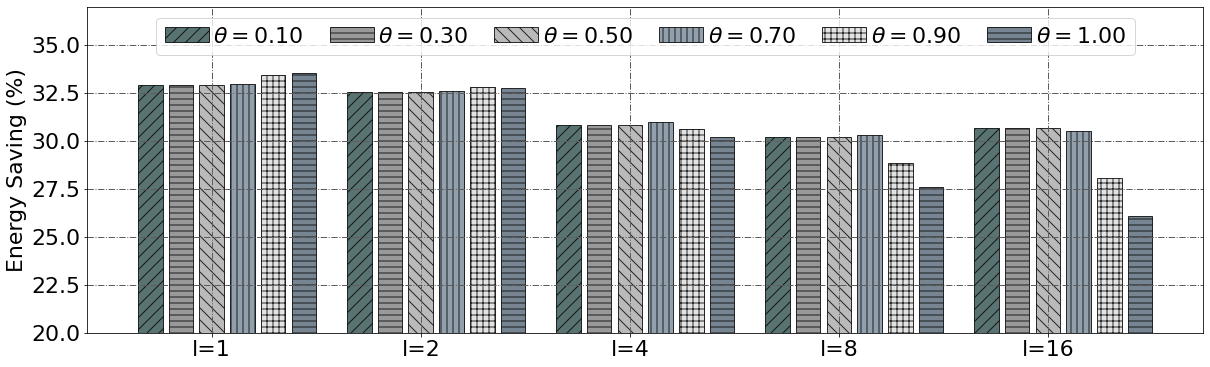

In [251]:
if __name__ == '__main__':
    
    #plot_real('real')
    #plot_app(apps='apps.pkl', save_filename='single_exp')
    #df = pd.read_csv("csvs/offline.csv", header = 0)
    #plot_normalize(df)
    #plot_lcurves(df, save_filename='offline_l')
    #plot_offline_dvfs(df, 'offline_dvfs_E')
    #plot_offline_theta(df, 'offline_theta')
    
    #df = pd.read_csv("csvs/turnon.csv", header = 0)
    #plot_turnon(df, 'offline_nodes')
    df = pd.read_csv("csvs/online.csv", header = 0)
    #print(df[(df.algo == 'edf+bin') & (df.gpus_per_node == 16)])
    #plot_curves(df, save_filename='E_dvfs_line')
    #plot_dist(df, save_filename='E_dvfs_bar')
    #plot_bar(df, save_filename='E_dvfs_theta')
    plot_online_saving(df, save_filename='online_dvfs_saving')
